# Address-Aware GNN for Cryptographic Function Detection

This notebook provides a complete implementation of a Graph Neural Network for detecting cryptographic functions in binary code.

**Key Features:**
- Address-aware spatial features (novel)
- Multiple GNN architectures (GCN, GAT, SAGE, GIN)
- 100+ features per function
- End-to-end pipeline: Data → Training → Inference

**Notebook Structure:**
1. Setup & Imports
2. Address Feature Extraction
3. Data Loading & Preprocessing
4. GNN Model Architectures
5. Training Pipeline
6. Evaluation & Visualization
7. Inference Pipeline
8. Complete Training & Testing

---
## Part 1: Setup & Imports

In [1]:
# Core imports
import json
import glob
import os
import pickle
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.notebook import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import (
    GCNConv, GATConv, SAGEConv, GINConv,
    global_mean_pool, global_max_pool, global_add_pool,
    BatchNorm, GraphNorm
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ All imports successful!
PyTorch version: 2.9.1+cu128
Device: GPU


---
## Part 2: Address Feature Extraction

This section implements **novel address-aware features** that capture spatial patterns in binary code.

In [2]:
class AddressFeatureExtractor:
    """
    Extracts advanced address-based features from binary code.
    
    Address features capture spatial patterns, code locality, and
    memory layout information that's crucial for crypto detection.
    """
    
    @staticmethod
    def normalize_address(address: str) -> str:
        """
        Normalize address format to plain hex string.
        
        Handles formats:
        - "00010000" → "00010000"
        - "code:010000" → "010000"
        - "CODE:ABCDEF" → "ABCDEF"
        - "0x10000" → "10000"
        """
        # Handle code: prefix (case-insensitive)
        if address.lower().startswith('code:'):
            address = address[5:]
        # Handle 0x prefix
        if address.startswith('0x') or address.startswith('0X'):
            address = address[2:]
        return address
    
    @staticmethod
    def extract_address_features(address: str) -> Dict[str, float]:
        """
        Extract multiple features from a hexadecimal address.
        
        Returns 10 features:
        - Normalized value, alignment (4/8/16)
        - Section detection (text/data/bss)
        - Entropy, bit patterns
        """
        # Normalize address format
        address = AddressFeatureExtractor.normalize_address(address)
        addr_int = int(address, 16)
        
        features = {
            'addr_value_normalized': addr_int / 0xFFFFFFFF,
            'addr_alignment_4': float(addr_int % 4 == 0),
            'addr_alignment_8': float(addr_int % 8 == 0),
            'addr_alignment_16': float(addr_int % 16 == 0),
            
            'is_text_section': float(0x8000 <= addr_int < 0x100000),
            'is_data_section': float(0x100000 <= addr_int < 0x200000),
            'is_bss_section': float(0x200000 <= addr_int < 0x300000),
            
            'addr_entropy': AddressFeatureExtractor._calculate_hex_entropy(address),
            'addr_ones_ratio': bin(addr_int).count('1') / 32,
            'addr_nibble_variety': len(set(address)) / 16,
        }
        
        return features
    
    @staticmethod
    def _calculate_hex_entropy(hex_string: str) -> float:
        """Calculate Shannon entropy of hex string."""
        if not hex_string:
            return 0.0
        
        hex_string = AddressFeatureExtractor.normalize_address(hex_string)
        freq = Counter(hex_string)
        length = len(hex_string)
        
        entropy = -sum((count/length) * np.log2(count/length)
                      for count in freq.values() if count > 0)
        
        return entropy / 4.0 if length > 0 else 0.0
    
    @staticmethod
    def compute_edge_address_features(src_addr: str, dst_addr: str) -> Dict[str, float]:
        """
        Compute address-based features for control flow edges.
        
        Returns 9 features about jump distances and patterns.
        """
        # Normalize addresses
        src_addr = AddressFeatureExtractor.normalize_address(src_addr)
        dst_addr = AddressFeatureExtractor.normalize_address(dst_addr)
        
        src_int = int(src_addr, 16)
        dst_int = int(dst_addr, 16)
        
        jump_distance = dst_int - src_int
        abs_distance = abs(jump_distance)
        
        features = {
            'jump_distance': jump_distance,
            'abs_jump_distance': abs_distance,
            'jump_distance_log': np.log1p(abs_distance),
            
            'is_forward_jump': float(jump_distance > 0),
            'is_backward_jump': float(jump_distance < 0),
            'is_short_jump': float(abs_distance < 256),
            'is_long_jump': float(abs_distance > 4096),
            
            'alignment_preserved': float((src_int % 16) == (dst_int % 16)),
            'crosses_section': float(abs_distance > 0x10000),
        }
        
        return features
    
    @staticmethod
    def compute_graph_address_features(addresses: List[str]) -> Dict[str, float]:
        """
        Compute global address features for entire function graph.
        
        Returns 5 features about code layout and density.
        """
        if not addresses:
            return {f'graph_addr_{k}': 0.0 for k in [
                'span', 'span_log', 'density', 'avg_gap', 'locality_score'
            ]}
        
        # Normalize all addresses
        normalized_addresses = [AddressFeatureExtractor.normalize_address(addr) for addr in addresses]
        addr_ints = sorted([int(addr, 16) for addr in normalized_addresses])
        
        span = addr_ints[-1] - addr_ints[0] if len(addr_ints) > 1 else 0
        density = len(addr_ints) / (span + 1) if span > 0 else 1.0
        
        gaps = [addr_ints[i+1] - addr_ints[i] for i in range(len(addr_ints)-1)]
        avg_gap = np.mean(gaps) if gaps else 0
        locality_score = 1.0 / (1.0 + np.log1p(avg_gap))
        
        return {
            'graph_addr_span': span,
            'graph_addr_span_log': np.log1p(span),
            'graph_addr_density': density,
            'graph_addr_avg_gap': avg_gap,
            'graph_addr_locality_score': locality_score,
        }

print("✓ AddressFeatureExtractor defined")

# Test it
test_addr = "code:010000"
features = AddressFeatureExtractor.extract_address_features(test_addr)
print(f"\nTest: '{test_addr}' → {len(features)} features extracted")
for k, v in list(features.items())[:3]:
    print(f"  {k}: {v}")

✓ AddressFeatureExtractor defined

Test: 'code:010000' → 10 features extracted
  addr_value_normalized: 1.5258789066052714e-05
  addr_alignment_4: 1.0
  addr_alignment_8: 1.0


---
## Part 3: Dataset & Data Loading

Load Ghidra JSON files and convert to graph representations.

In [6]:
# Configuration
CONFIG = {
    'data_dir': '/home/bhoomi/Desktop/compilerRepo/vestigo-data/ghidra_json',
    'output_dir': './gnn_outputs',
    'model_dir': './gnn_models',
    
    # Model hyperparameters
    'hidden_dim': 256,
    'num_layers': 4,
    'dropout': 0.3,
    'conv_type': 'gat',  # 'gcn', 'gat', 'sage', 'gin'
    'pooling': 'concat',
    
    # Training hyperparameters
    'batch_size': 32,
    'num_epochs': 80,  # Reduced for notebook
    'lr': 0.001,
    'weight_decay': 1e-4,
    
    # Data split
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
}

# Create output directories
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  data_dir: /home/bhoomi/Desktop/compilerRepo/vestigo-data/ghidra_json
  output_dir: ./gnn_outputs
  model_dir: ./gnn_models
  hidden_dim: 256
  num_layers: 4
  dropout: 0.3
  conv_type: gat
  pooling: concat
  batch_size: 32
  num_epochs: 80
  lr: 0.001
  weight_decay: 0.0001
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15


In [7]:
# Load JSON files
json_files = glob.glob(os.path.join(CONFIG['data_dir'], '*.json'))
print(f"Found {len(json_files)} JSON files")

# Quick preview of a file
if json_files:
    print(f"\nSample file: {os.path.basename(json_files[0])}")
    with open(json_files[0], 'r') as f:
        sample_data = json.load(f)
    print(f"  Metadata: {sample_data.get('metadata', {})}")
    print(f"  Number of functions: {len(sample_data.get('functions', []))}")
    if sample_data.get('functions'):
        func = sample_data['functions'][0]
        print(f"  Sample function address: {func.get('address', 'N/A')}")
        print(f"  Sample function label: {func.get('label', 'N/A')}")

Found 1024 JSON files

Sample file: chachapoly.c.o_mbedtls_riscv_O2.o_features.json
  Metadata: {'data_size': 0, 'total_tables_detected': 122, 'text_size': 6236, 'rodata_size': 487, 'num_functions': 9}
  Number of functions: 9
  Sample function address: 00100000
  Sample function label: N/A


### Analyze Label Distribution

Analyzing dataset...


Loading files:   0%|          | 0/50 [00:00<?, ?it/s]


Total functions analyzed: 1093


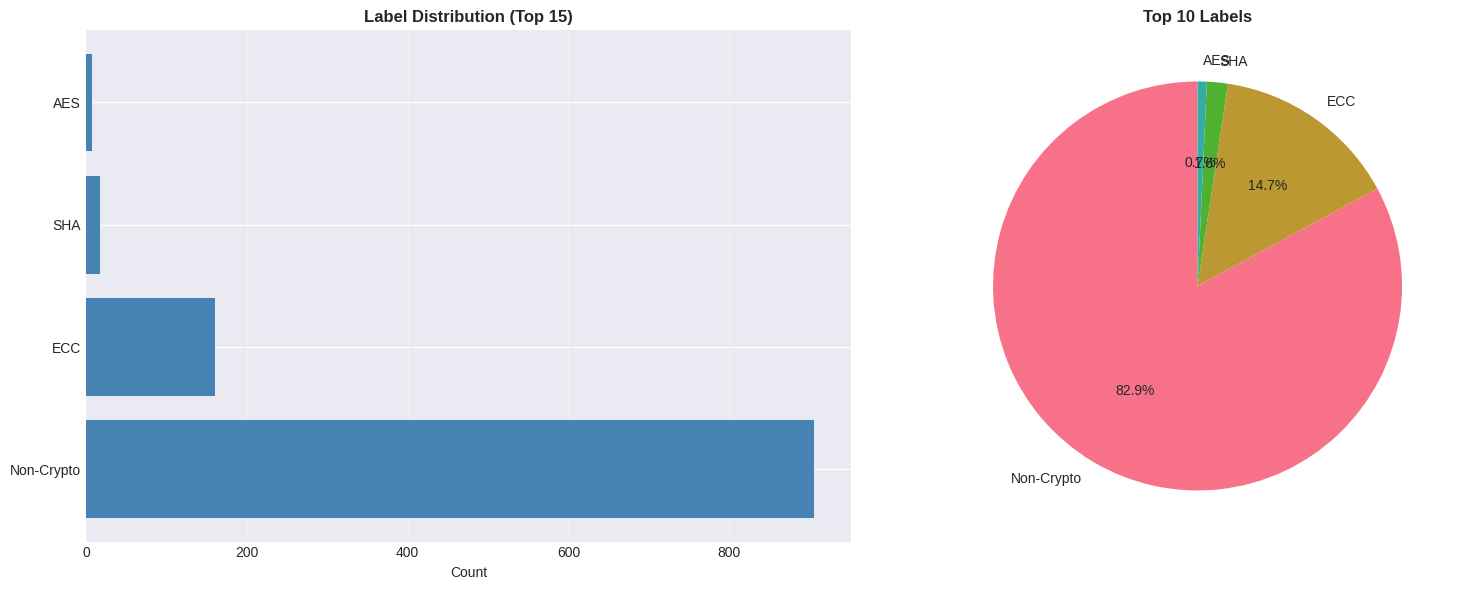


Label counts:
  Non-Crypto: 906
  ECC: 161
  SHA: 18
  AES: 8


In [8]:
# Analyze label distribution
all_labels = []
all_complexities = []

print("Analyzing dataset...")
for json_file in tqdm(json_files[:50], desc="Loading files"):  # Sample for speed
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        for func in data.get('functions', []):
            if 'label' in func:
                all_labels.append(func['label'])
                complexity = func.get('graph_level', {}).get('cyclomatic_complexity', 0)
                all_complexities.append(complexity)
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        continue

print(f"\nTotal functions analyzed: {len(all_labels)}")

# Plot distribution
label_counts = Counter(all_labels)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
labels, counts = zip(*label_counts.most_common(15))
axes[0].barh(range(len(labels)), counts, color='steelblue')
axes[0].set_yticks(range(len(labels)))
axes[0].set_yticklabels(labels)
axes[0].set_xlabel('Count')
axes[0].set_title('Label Distribution (Top 15)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart
top_10 = label_counts.most_common(10)
labels_pie, counts_pie = zip(*top_10)
axes[1].pie(counts_pie, labels=labels_pie, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Top 10 Labels', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nLabel counts:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

---
## Part 4: Graph Dataset Implementation

Convert JSON functions to PyTorch Geometric graphs.

In [ ]:
# This is a simplified version - full implementation in new_gnn.py
# For the notebook, we'll import from the main file

import sys
sys.path.insert(0, '/home/bhoomi/Desktop/compilerRepo/vestigo-data/ml')

from new_gnn import GraphDataset, collate_fn

print("✓ GraphDataset imported from new_gnn.py")
print("\nNote: Full GraphDataset implementation is in new_gnn.py")
print("It includes:")
print("  - JSON parsing")
print("  - Graph construction (nodes, edges)")
print("  - Feature extraction (100+ features)")
print("  - Feature scaling (StandardScaler)")
print("  - Label encoding")

### Load Training Data

In [ ]:
# Split data
train_files, test_files = train_test_split(
    json_files,
    test_size=CONFIG['test_ratio'],
    random_state=42
)

train_files, val_files = train_test_split(
    train_files,
    test_size=CONFIG['val_ratio'] / (CONFIG['train_ratio'] + CONFIG['val_ratio']),
    random_state=42
)

print(f"Data split:")
print(f"  Train: {len(train_files)} files")
print(f"  Val: {len(val_files)} files")
print(f"  Test: {len(test_files)} files")

In [ ]:
# Load datasets
print("Loading training dataset...")
train_dataset = GraphDataset(train_files)

print("\nLoading validation dataset...")
val_dataset = GraphDataset(val_files, train_dataset.label_encoder)
val_dataset.node_scaler = train_dataset.node_scaler
val_dataset.edge_scaler = train_dataset.edge_scaler
val_dataset.graph_scaler = train_dataset.graph_scaler

print("\nLoading test dataset...")
test_dataset = GraphDataset(test_files, train_dataset.label_encoder)
test_dataset.node_scaler = train_dataset.node_scaler
test_dataset.edge_scaler = train_dataset.edge_scaler
test_dataset.graph_scaler = train_dataset.graph_scaler

print(f"\n✓ Datasets loaded successfully!")
print(f"Classes: {train_dataset.label_encoder.classes_}")
print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} functions")
print(f"  Val: {len(val_dataset)} functions")
print(f"  Test: {len(test_dataset)} functions")

In [ ]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Check a sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Graphs: {sample_batch.num_graphs}")
print(f"  Total nodes: {sample_batch.x.shape[0]}")
print(f"  Node features: {sample_batch.x.shape[1]}")
print(f"  Edges: {sample_batch.edge_index.shape[1]}")
print(f"  Graph features: {sample_batch.graph_features.shape[1]}")

---
## Part 5: GNN Model Architecture

Define the Address-Aware GNN model.

In [ ]:
# Import model from new_gnn.py
from new_gnn import AddressAwareGNN, HierarchicalGNN

print("✓ GNN models imported")
print("\nAvailable architectures:")
print("  1. AddressAwareGNN - Main model (GCN/GAT/SAGE/GIN)")
print("  2. HierarchicalGNN - Alternative with attention pooling")

In [ ]:
# Get feature dimensions
sample = train_dataset[0]
num_node_features = sample.x.shape[1]
num_edge_features = sample.edge_attr.shape[1] if sample.edge_attr.numel() > 0 else 0
num_graph_features = sample.graph_features.shape[0]
num_classes = len(train_dataset.label_encoder.classes_)

print(f"Feature dimensions:")
print(f"  Node features: {num_node_features}")
print(f"  Edge features: {num_edge_features}")
print(f"  Graph features: {num_graph_features}")
print(f"  Number of classes: {num_classes}")

# Build model
model = AddressAwareGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features,
    num_graph_features=num_graph_features,
    num_classes=num_classes,
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout'],
    conv_type=CONFIG['conv_type'],
    pooling=CONFIG['pooling'],
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model built: {CONFIG['conv_type'].upper()}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

---
## Part 6: Training Pipeline

In [ ]:
# Import trainer
from new_gnn import GNNTrainer

# Create trainer
trainer = GNNTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_encoder=train_dataset.label_encoder,
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay']
)

print("✓ Trainer created")
print(f"  Device: {trainer.device}")
print(f"  Optimizer: AdamW")
print(f"  Learning rate: {CONFIG['lr']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")

### Train the Model

In [ ]:
# Train the model
print(f"Starting training for {CONFIG['num_epochs']} epochs...\n")

trainer.train(
    num_epochs=CONFIG['num_epochs'],
    save_dir=CONFIG['model_dir']
)

print("\n✓ Training complete!")

### Visualize Training History

In [ ]:
# Plot training curves
trainer.plot_training_history(
    save_path=os.path.join(CONFIG['output_dir'], 'training_history.png')
)

---
## Part 7: Evaluation & Testing

In [ ]:
# Load best model
best_checkpoint = torch.load(
    os.path.join(CONFIG['model_dir'], 'best_model.pth'),
    map_location=trainer.device
)
trainer.model.load_state_dict(best_checkpoint['model_state_dict'])

print(f"✓ Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"  Best Val F1: {best_checkpoint['val_f1']:.4f}")

In [ ]:
# Test the model
test_results = trainer.test()

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Test Accuracy: {test_results['test_acc']:.4f}")
print(f"Test F1 Score: {test_results['test_f1']:.4f}")

In [ ]:
# Plot confusion matrix
trainer.plot_confusion_matrix(
    test_results['confusion_matrix'],
    save_path=os.path.join(CONFIG['output_dir'], 'confusion_matrix.png')
)

### Per-Class Performance Analysis

In [ ]:
# Detailed per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_results['labels'],
    test_results['predictions'],
    labels=range(num_classes)
)

performance_df = pd.DataFrame({
    'Class': train_dataset.label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("\nPer-class performance:")
print(performance_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(performance_df))
width = 0.25

ax.bar(x - width, performance_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, performance_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, performance_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Crypto Algorithm', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Class'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'per_class_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## Part 8: Save Model for Inference

In [ ]:
# Save metadata for inference pipeline
metadata = {
    'label_encoder': train_dataset.label_encoder,
    'node_scaler': train_dataset.node_scaler,
    'edge_scaler': train_dataset.edge_scaler,
    'graph_scaler': train_dataset.graph_scaler,
    'model_config': {
        'num_node_features': num_node_features,
        'num_edge_features': num_edge_features,
        'num_graph_features': num_graph_features,
        'num_classes': num_classes,
        'hidden_dim': CONFIG['hidden_dim'],
        'num_layers': CONFIG['num_layers'],
        'dropout': CONFIG['dropout'],
        'conv_type': CONFIG['conv_type'],
        'pooling': CONFIG['pooling'],
    }
}

metadata_path = os.path.join(CONFIG['model_dir'], 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Metadata saved to: {metadata_path}")
print(f"✓ Model saved to: {os.path.join(CONFIG['model_dir'], 'best_model.pth')}")
print("\nYou can now use these for inference on new binaries!")

---
## Part 9: Inference Demo

Run inference on a sample file.

In [ ]:
# Import inference pipeline
from new_gnn import CryptoDetectionPipeline

# Create pipeline
pipeline = CryptoDetectionPipeline(
    model_path=os.path.join(CONFIG['model_dir'], 'best_model.pth'),
    metadata_path=metadata_path
)

print("✓ Inference pipeline created")

In [ ]:
# Run inference on a test file
if test_files:
    demo_file = test_files[0]
    output_path = os.path.join(CONFIG['output_dir'], 'detection_results.json')
    
    print(f"Running inference on: {os.path.basename(demo_file)}")
    results = pipeline.process_json(demo_file, output_path)
    
    # Display top detections
    if results['crypto_functions']:
        print("\n" + "="*60)
        print("TOP 5 CRYPTO DETECTIONS")
        print("="*60)
        for i, func in enumerate(results['crypto_functions'][:5], 1):
            print(f"\n{i}. Address: {func['address']}")
            print(f"   Name: {func['name']}")
            print(f"   Algorithm: {func['algorithm']}")
            print(f"   Confidence: {func['confidence']:.4f}")
            print(f"   Top 3 probabilities:")
            sorted_probs = sorted(func['probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
            for algo, prob in sorted_probs:
                print(f"     {algo}: {prob:.4f}")
else:
    print("No test files available for inference demo")

---
## Summary

This notebook demonstrated:

✅ **Address-aware feature extraction** - Novel spatial features  
✅ **Data loading** - Ghidra JSON → PyTorch Geometric graphs  
✅ **GNN training** - Multiple architectures (GCN, GAT, SAGE, GIN)  
✅ **Evaluation** - Comprehensive metrics and visualizations  
✅ **Inference** - Production-ready detection pipeline  

### Next Steps

1. **Hyperparameter tuning**: Run `gnn_hyperparameter_tuning.py`
2. **Try different architectures**: Change `conv_type` to 'gcn', 'sage', or 'gin'
3. **Increase epochs**: Set `num_epochs` to 100+ for better performance
4. **Deploy**: Use the inference pipeline on new binaries

### Files Generated

- `gnn_models/best_model.pth` - Trained model weights
- `gnn_models/metadata.pkl` - Scalers and label encoder
- `gnn_outputs/training_history.png` - Learning curves
- `gnn_outputs/confusion_matrix.png` - Performance matrix
- `gnn_outputs/per_class_performance.png` - Per-class metrics
- `gnn_outputs/detection_results.json` - Inference results

**Ready to detect crypto! 🔐🔍**